<a href="https://www.kaggle.com/code/buffyhridoy/ann-cnn?scriptVersionId=99542736" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df = pd.read_csv('../input/multimodal/ManualFeatures_sorted.csv')
df.head()

,Sl,image_names,Unnamed: 2,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,label
0,1,37958_left.jpeg,NaN,0.992162,0.991079,0.992386,0.986842,0.611848,0.553008,0.636166,0.549923,1.551542,1
1,2,37962_left.jpeg,NaN,0.985014,0.978970,0.992584,0.987428,0.793084,0.727095,0.801264,0.738245,0.921037,1
2,3,38064_left.jpeg,NaN,0.996914,0.994773,0.996789,0.994490,0.739831,0.692451,0.742398,0.694139,1.384981,1
3,4,38064_right.jpeg,NaN,0.996228,0.993847,0.996660,0.994188,0.755067,0.706689,0.754008,0.708507,1.265429,1
4,5,38186_left.jpeg,NaN,0.998866,0.998184,0.998900,0.998101,0.709288,0.635742,0.721018,0.629961,0.899769,1


In [3]:
len(df.image_names.unique()), len(df.image_names)

(300, 300)

In [4]:
len(os.listdir('../input/multimodal/data/normal1')), len(os.listdir('../input/multimodal/data/diaret1'))

(200, 100)

In [5]:
IMG_PATH_ONE = "/kaggle/input/multimodal" + "/data/diaret1/"
IMG_PATH_TWO = "/kaggle/input/multimodal" + "/data/normal1/"

In [6]:
paths = [
    os.path.join(dirpath,filename) 
    for dirpath, _, filenames in os.walk(IMG_PATH_ONE) 
    for filename in filenames if filename.endswith('.jpeg') and not filename.startswith(".")
]


paths2 = [
    os.path.join(dirpath,filename) 
    for dirpath, _, filenames in os.walk(IMG_PATH_TWO) 
    for filename in filenames if filename.endswith('.jpeg') and not filename.startswith(".")
]

full_paths = paths + paths2
len(paths + paths2), paths[0]

(300, '/kaggle/input/multimodal/data/diaret1/39164_right.jpeg')

In [7]:
def path_apply(x):
    for path in full_paths:
        if x == path.split('/')[-1]:
            return path

df['image_names'] = df['image_names'].apply(path_apply)

In [8]:
df.head()

,Sl,image_names,Unnamed: 2,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,label
0,1,/kaggle/input/multimodal/data/diaret1/37958_le...,NaN,0.992162,0.991079,0.992386,0.986842,0.611848,0.553008,0.636166,0.549923,1.551542,1
1,2,/kaggle/input/multimodal/data/diaret1/37962_le...,NaN,0.985014,0.978970,0.992584,0.987428,0.793084,0.727095,0.801264,0.738245,0.921037,1
2,3,/kaggle/input/multimodal/data/diaret1/38064_le...,NaN,0.996914,0.994773,0.996789,0.994490,0.739831,0.692451,0.742398,0.694139,1.384981,1
3,4,/kaggle/input/multimodal/data/diaret1/38064_ri...,NaN,0.996228,0.993847,0.996660,0.994188,0.755067,0.706689,0.754008,0.708507,1.265429,1
4,5,/kaggle/input/multimodal/data/diaret1/38186_le...,NaN,0.998866,0.998184,0.998900,0.998101,0.709288,0.635742,0.721018,0.629961,0.899769,1


In [9]:
df['image_names'][299]

'/kaggle/input/multimodal/data/normal1/44349_left.jpeg'

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)

In [11]:
train_df.shape

(240, 13)

In [12]:
val_df.shape

(60, 13)

In [13]:
meta_feat = [
    'F_1', 'F_2', 'F_3', 'F_4', 'F_5', 
    'F_6', 'F_7', 'F_8', 'F_9'
]

In [14]:
import tensorflow as tf

## tf.data API

- multi-input data loader

In [15]:
AUTOTUNE = tf.data.AUTOTUNE  
IMG_SIZE = 224
BATCH_SIZE = 64

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync

In [16]:

def build_decoder():
    
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = 3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) 
        return tf.divide(img, 255.)
    
    def decode_with_labels(path, label):
        image, feature = path 
        decode_image = decode(image)
        
        return (decode_image, feature), label 
    
    return decode_with_labels 


def build_augmenter():
    
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(path, label):
        image, feature = path 
        augment_image = augment(image)
        return (augment_image, feature), label
    
    return augment_with_labels


def create_dataset(
    df, 
    batch_size  = 32, 
    augment     = False,
    shuffle     = False
):
    if augment:
        augmenter_fn = build_augmenter()
    decode_fn = build_decoder()
    
    # prepare slices
    dataset_sample = tf.data.Dataset.from_tensor_slices(
        (df['image_names'].values, df[meta_feat].values)
    )
    dataset_labels = tf.data.Dataset.from_tensor_slices(
        df['label'].values
    )
    dataset = tf.data.Dataset.zip((dataset_sample, dataset_labels))

    # read data
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(augmenter_fn, num_parallel_calls = AUTOTUNE) if augment else dataset
    
    # shuffling, batching etc
    dataset = dataset.shuffle(1024 * REPLICAS) if shuffle else dataset
    dataset = dataset.batch(batch_size * REPLICAS, drop_remainder=shuffle)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [17]:
training_dataset = create_dataset(
    train_df, 
    batch_size  = BATCH_SIZE, 
    augment = True,
    shuffle = True
)

validation_dataset = create_dataset(
    val_df, 
    batch_size = BATCH_SIZE, 
    augment = False,
    shuffle = False
)

2022-06-28 16:19:23.786511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:19:23.915350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:19:23.916141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:19:23.918089: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**check dataloader**

In [18]:
(sample_images, sample_feature), sample_labels = next(iter(training_dataset))
print(sample_images.shape, sample_feature.shape, sample_labels.shape)

2022-06-28 16:19:26.958526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 224, 224, 3) (64, 9) (64,)


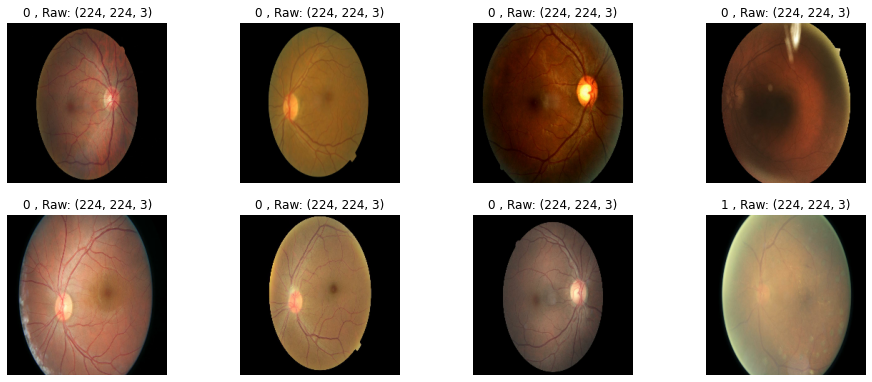

In [19]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16, 10))

for i, (image, label) in enumerate(zip(sample_images[:8], sample_labels[:8])):
    ax = plt.subplot(3, 4, i + 1)
    plt.title(f'{label.numpy()} , Raw: {image.numpy().shape}')
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

In [20]:
from tensorflow import keras

In [21]:
# feature model
pool_size= (2,2)
first_filters = 64
second_filters = 128
third_filters = 256

dropout_conv = 0.3
dropout_dense = 0.3
kernel_size = (3,3)


feat = keras.Input(shape=(9, ))
feat_hidden = keras.layers.Dense(10, activation='relu')(feat)

# vision model
vision_model = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
vision_model1 = keras.layers.Conv2D(first_filters, kernel_size, activation = 'relu')(vision_model)
vision_model2 = keras.layers.Conv2D(first_filters, kernel_size, activation = 'relu')(vision_model1)
vision_model3 = keras.layers.Conv2D(first_filters, kernel_size, activation = 'relu')(vision_model2)
# vision_model = keras.layers.MaxPooling2D(pool_size = pool_size)(vision_model)
# vision_model = keras.layers.Dropout(dropout_conv)(vision_model)
vision_model_hidden = keras.layers.Flatten()(vision_model3)
vision_model_hidden = keras.layers.Dense(64, activation='relu')(vision_model_hidden)

# Possibly add more hidden layers, then merge
fusion = keras.layers.Concatenate()([vision_model_hidden, feat_hidden])

In [22]:
# create last layer.
out = keras.layers.Dense(1, activation='sigmoid')(fusion)

# build model
model = keras.Model([vision_model, feat], out)
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics = ['accuracy']
) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 218, 218, 64) 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

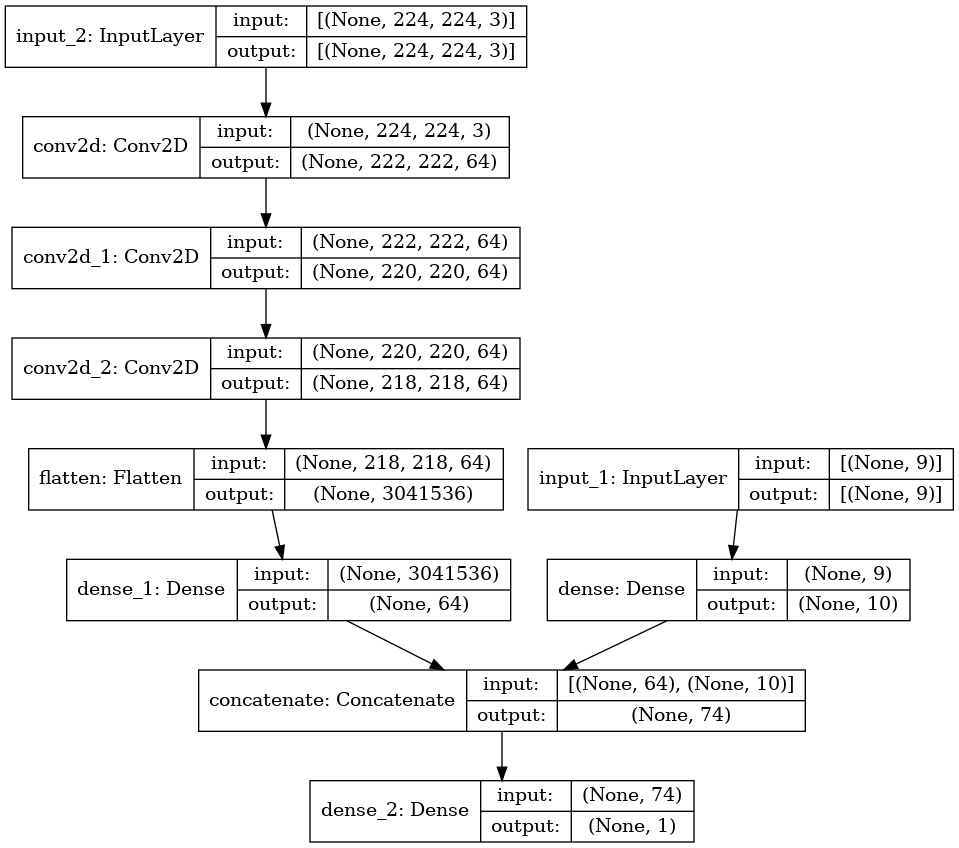

In [23]:
keras.utils.plot_model(model, show_shapes=True)

In [24]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs = 100,
    steps_per_epoch  = train_df.shape[0] / BATCH_SIZE // REPLICAS
)   

Epoch 1/100


2022-06-28 16:19:33.863055: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 [==============================] - 11s 812ms/step - loss: 12.6405 - accuracy: 0.5625 - val_loss: 21.3772 - val_accuracy: 0.5833
Epoch 2/100
3/3 [==============================] - 2s 360ms/step - loss: 8.2029 - accuracy: 0.6510 - val_loss: 1.2507 - val_accuracy: 0.4833
Epoch 3/100
3/3 [==============================] - 2s 348ms/step - loss: 1.5616 - accuracy: 0.5625 - val_loss: 1.5506 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 2s 345ms/step - loss: 1.0736 - accuracy: 0.5677 - val_loss: 1.0805 - val_accuracy: 0.5833
Epoch 5/100
3/3 [==============================] - 2s 346ms/step - loss: 0.6777 - accuracy: 0.6615 - val_loss: 0.6851 - val_accuracy: 0.5667
Epoch 6/100
3/3 [==============================] - 2s 346ms/step - loss: 0.6028 - accuracy: 0.6771 - val_loss: 0.7978 - val_accuracy: 0.5833
Epoch 7/100
3/3 [==============================] - 2s 346ms/step - loss: 0.5416 - accuracy: 0.7396 - val_loss: 0.7531 - val_accuracy: 0.5833
Epoch 8/100
3/3 [=====